In [21]:
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import os
from sklearn.manifold import TSNE
import seaborn as sns
import sys
import pickle
import pandas as pd
from sklearn.metrics import confusion_matrix
from PIL import Image

In [2]:
sys.path.append(os.path.join(os.getcwd(), '..'))
from utils import set_seed, log_results, load_model
from models.vit import VisionTransformer
from models.performer_relu import PerformerReLUTransformer
from models.performer_exp import PerformerExpTransformer
from models.performer_f_theta import PerformerLearnableTransformer
os.chdir('..')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_workers = os.cpu_count() if os.cpu_count() is not None else 4
print(f"using device: {device}, num_workers: {num_workers}")

# Set seed for reproducibility
set_seed(42)

# Define data transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010]
    ),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010]
    ),
])

using device: cpu, num_workers: 11


In [4]:
# Load datasets
train_dataset = datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

# Create data loaders
batch_size = 256
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Define criterion
criterion = nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Initialize models with adjusted parameters for efficiency
vit_model = VisionTransformer(
    img_size=32,
    patch_size=8,            # Increased patch size from 4 to 8
    in_channels=3,
    num_classes=10,
    embed_dim=128,           # Reduced embedding dimension from 256 to 128
    num_heads=4,             # Reduced number of heads from 8 to 4
    hidden_dim=256,          # Reduced hidden dimension from 512 to 256
    num_layers=4,            # Reduced number of layers from 6 to 4
    dropout=0.1
).to(device)

performer_relu_model = PerformerReLUTransformer(
    img_size=32,
    patch_size=8,            # Increased patch size from 4 to 8
    in_channels=3,
    num_classes=10,
    embed_dim=128,           # Reduced embedding dimension from 256 to 128
    num_heads=4,             # Reduced number of heads from 8 to 4
    hidden_dim=256,          # Reduced hidden dimension from 512 to 256
    num_layers=4,            # Reduced number of layers from 6 to 4
    dropout=0.1
).to(device)

performer_exp_model = PerformerExpTransformer(
    img_size=32,
    patch_size=8,            # Increased patch size from 4 to 8
    in_channels=3,
    num_classes=10,
    embed_dim=128,           # Reduced embedding dimension from 256 to 128
    num_heads=4,             # Reduced number of heads from 8 to 4
    hidden_dim=256,          # Reduced hidden dimension from 512 to 256
    num_layers=4,            # Reduced number of layers from 6 to 4
    num_features=128,        # Adjusted num_features to match reduced embed_dim
    dropout=0.1
).to(device)

performer_learnable_model = PerformerLearnableTransformer(
    img_size=32,
    patch_size=8,            # Increased patch size from 4 to 8
    in_channels=3,
    num_classes=10,
    embed_dim=128,           # Reduced embedding dimension from 256 to 128
    num_heads=4,             # Reduced number of heads from 8 to 4
    hidden_dim=256,          # Reduced hidden dimension from 512 to 256
    num_layers=4,            # Reduced number of layers from 6 to 4
    num_features=128,        # Adjusted num_features to match reduced embed_dim
    dropout=0.1
).to(device)

# # Define optimizers
# optimizer_vit = optim.AdamW(vit_model.parameters(), lr=0.001, weight_decay=0.01)
# optimizer_relu = optim.AdamW(performer_relu_model.parameters(), lr=0.001, weight_decay=0.01)
# optimizer_exp = optim.AdamW(performer_exp_model.parameters(), lr=0.001, weight_decay=0.01)
# optimizer_learnable = optim.AdamW(performer_learnable_model.parameters(), lr=0.001, weight_decay=0.01)

# # Define schedulers
# scheduler_vit = optim.lr_scheduler.CosineAnnealingLR(optimizer_vit, T_max=50)
# scheduler_relu = optim.lr_scheduler.CosineAnnealingLR(optimizer_relu, T_max=50)
# scheduler_exp = optim.lr_scheduler.CosineAnnealingLR(optimizer_exp, T_max=50)
# scheduler_learnable = optim.lr_scheduler.CosineAnnealingLR(optimizer_learnable, T_max=50)


In [10]:
# Models dictionary
models = {
    "ViT": {
        "model": vit_model,
        # "optimizer": optimizer_vit,
        # "scheduler": scheduler_vit,
    },
    "Performer-ReLU": {
        "model": performer_relu_model,
        # "optimizer": optimizer_relu,
        # "scheduler": scheduler_relu,
    },
    "Performer-exp": {
        "model": performer_exp_model,
        # "optimizer": optimizer_exp,
        # "scheduler": scheduler_exp,
    },
    "Performer-Learnable": {
        "model": performer_learnable_model,
        # "optimizer": optimizer_learnable,
        # "scheduler": scheduler_learnable,
    },
}


In [8]:
# for model_name, components in models.items():
#         model = components["model"]
#         optimizer = components["optimizer"]
#         scheduler = components["scheduler"]
        
#         # Check if a checkpoint exists
#         checkpoint_path = f'best_{model_name}.pth'
#         print(checkpoint_path)


best_ViT.pth
best_Performer-ReLU.pth
best_Performer-exp.pth
best_Performer-Learnable.pth


In [11]:
# Function to load the checkpoints
def load_checkpoint(model, checkpoint_path):
    if os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from '{checkpoint_path}'")
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        else:
            model.load_state_dict(checkpoint)
        print("Checkpoint loaded successfully.")
    else:
        print(f"No checkpoint found at '{checkpoint_path}'. Starting from scratch.")
    return model

# Load the checkpoints
vit_model = load_checkpoint(vit_model, 'best_ViT.pth')
performer_relu_model = load_checkpoint(performer_relu_model, 'best_Performer-ReLU.pth')
performer_exp_model = load_checkpoint(performer_exp_model, 'best_Performer-exp.pth')
performer_learnable_model = load_checkpoint(performer_learnable_model, 'best_Performer-Learnable.pth')

# Set models to evaluation mode
vit_model.eval()
performer_relu_model.eval()
performer_exp_model.eval()
performer_learnable_model.eval()
print("done")

Loading checkpoint from 'best_ViT.pth'
Checkpoint loaded successfully.
Loading checkpoint from 'best_Performer-ReLU.pth'
Checkpoint loaded successfully.
Loading checkpoint from 'best_Performer-exp.pth'
Checkpoint loaded successfully.
Loading checkpoint from 'best_Performer-Learnable.pth'
Checkpoint loaded successfully.
done


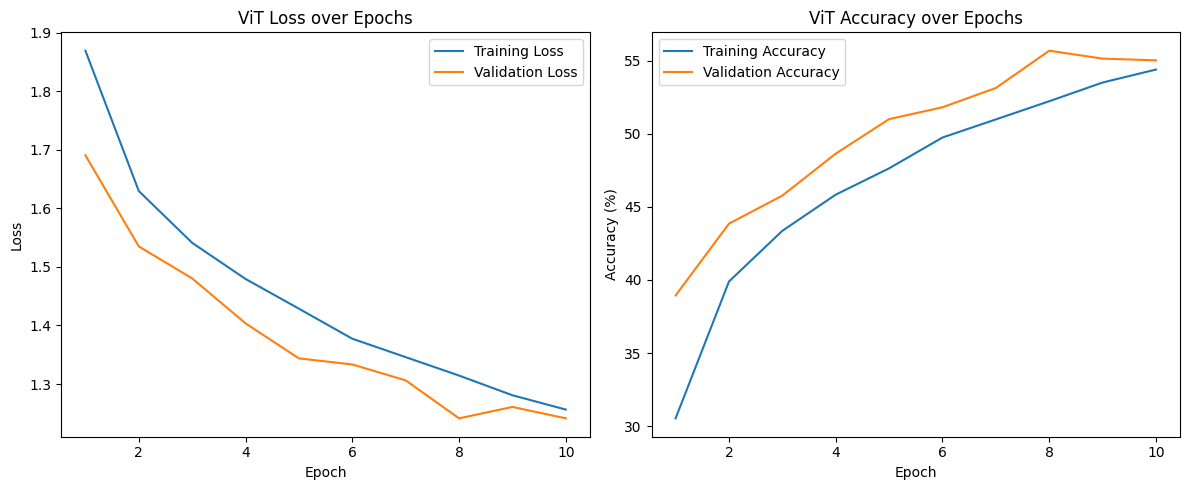

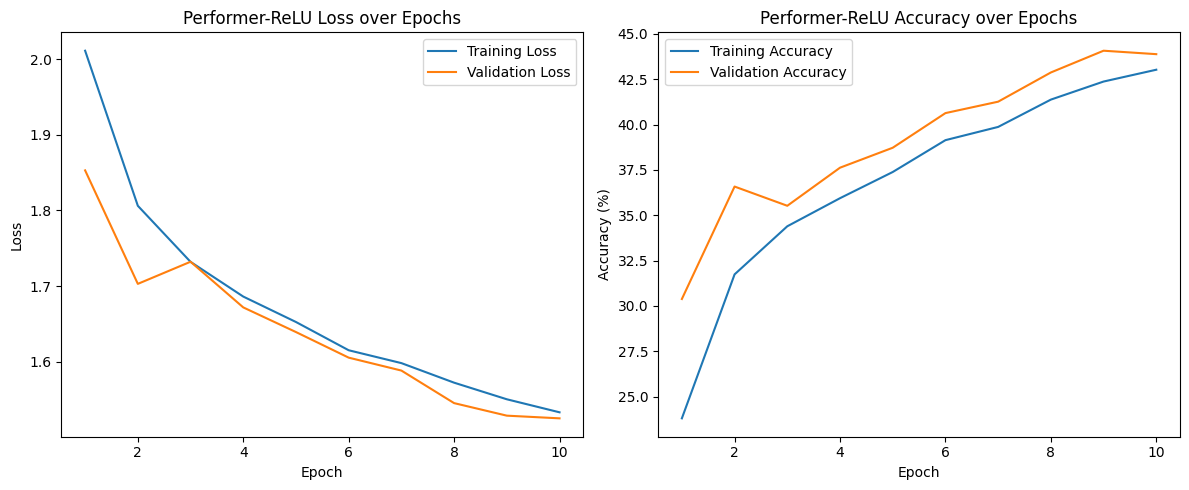

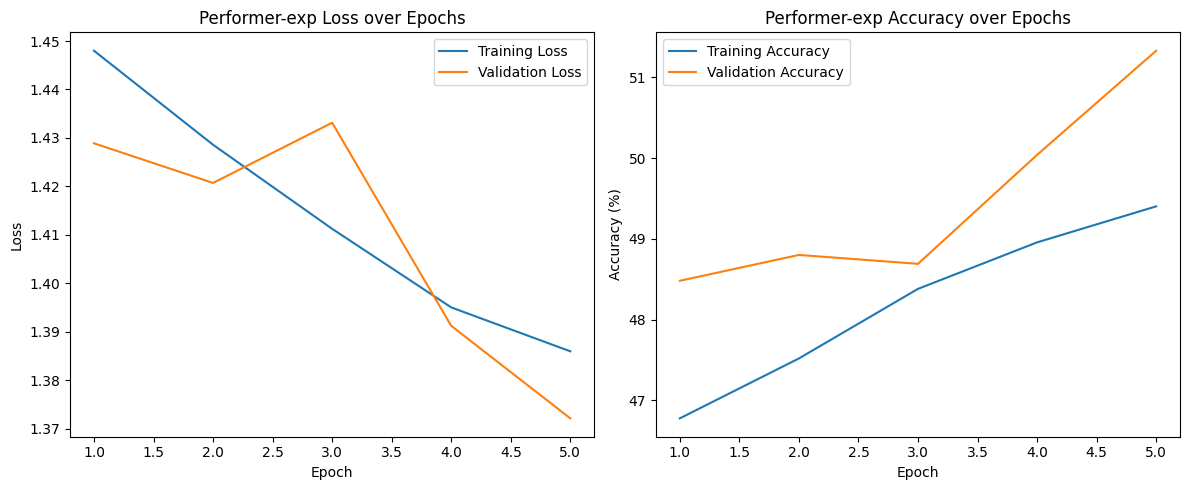

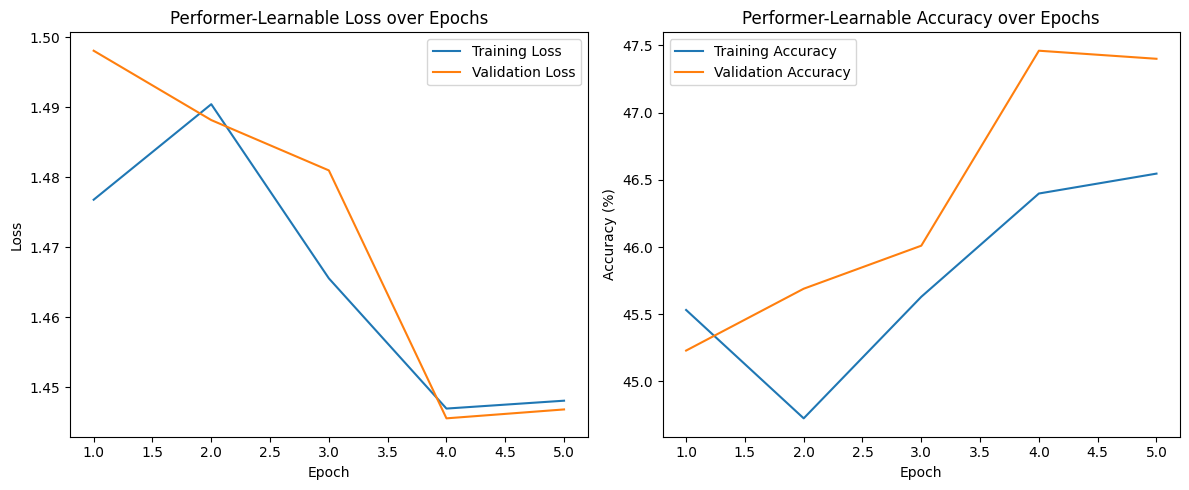

In [12]:
def plot_metrics(model_name):
    with open(f'{model_name}_metrics.pkl', 'rb') as f:
        metrics = pickle.load(f)

    epochs = range(1, len(metrics['train_losses']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics['train_losses'], label='Training Loss')
    plt.plot(epochs, metrics['val_losses'], label='Validation Loss')
    plt.title(f'{model_name} Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics['train_accuracies'], label='Training Accuracy')
    plt.plot(epochs, metrics['val_accuracies'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_metrics('ViT')
plot_metrics('Performer-ReLU')
plot_metrics('Performer-exp')
plot_metrics('Performer-Learnable')

In [18]:
def get_embeddings(model, dataloader, device):
    model.eval()
    embeddings = []
    labels_list = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Extracting Embeddings'):
            images = images.to(device)
            labels = labels.to(device)

            if hasattr(model, 'get_embeddings'):
                cls_output = model.get_embeddings(images)
            else:
                x = model.patch_embed(images)
                batch_size = x.size(0)
                cls_tokens = model.cls_token.expand(batch_size, -1, -1)
                x = torch.cat((cls_tokens, x), dim=1)
                x = model.pos_embed(x)
                x = model.dropout(x)
                x = model.encoder(x)
                cls_output = x[:, 0]

            embeddings.append(cls_output.cpu().numpy())
            labels_list.append(labels.cpu().numpy())

    embeddings = np.concatenate(embeddings)
    labels_list = np.concatenate(labels_list)
    return embeddings, labels_list

def tsne_transform(embeddings):
    tsne = TSNE(n_components=2, perplexity=30, n_iter=500, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    return embeddings_2d

def plot_embeddings(embeddings_2d, labels, ax, model_name):
    num_classes = len(np.unique(labels))
    sns.scatterplot(
        x=embeddings_2d[:, 0],
        y=embeddings_2d[:, 1],
        hue=labels,
        palette=sns.color_palette("hls", num_classes),
        legend=None,
        alpha=0.7,
        s=10,
        ax=ax
    )
    ax.set_title(f'{model_name}')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])


Extracting Embeddings: 100%|██████████| 40/40 [01:17<00:00,  1.93s/it]
/Users/GuidoDeFilippo/Columbia/Data_Mining/transformer_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/Users/GuidoDeFilippo/Columbia/Data_Mining/transformer_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/Users/GuidoDeFilippo/Columbia/Data_Mining/transformer_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/Users/GuidoDeFilippo/Columbia/Data_Mining/transformer_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


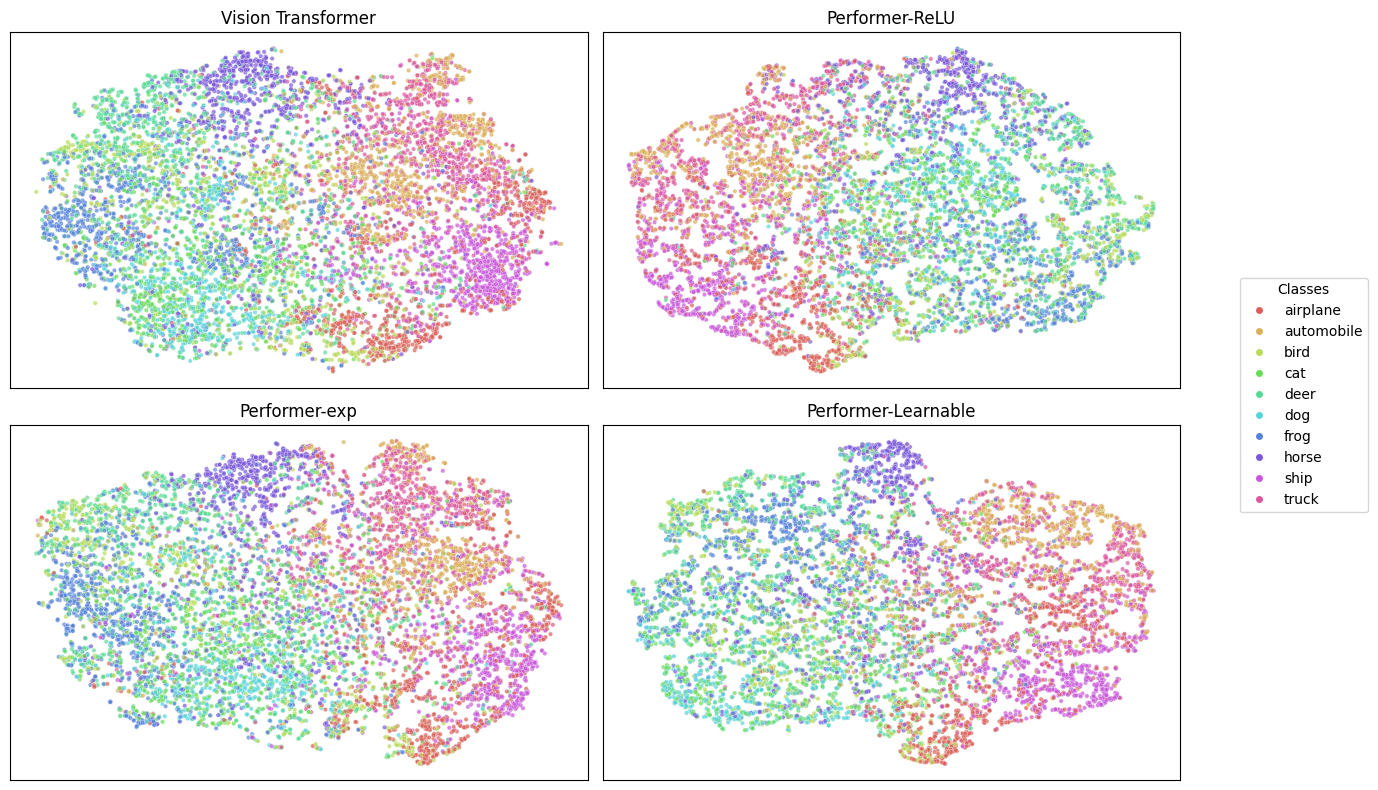

In [19]:
# Extract embeddings
vit_embeddings, vit_labels = get_embeddings(vit_model, test_loader, device)
performer_relu_embeddings, performer_relu_labels = get_embeddings(performer_relu_model, test_loader, device)
performer_exp_embeddings, performer_exp_labels = get_embeddings(performer_exp_model, test_loader, device)
performer_learnable_embeddings, performer_learnable_labels = get_embeddings(performer_learnable_model, test_loader, device)

# Apply t-SNE
vit_embeddings_2d = tsne_transform(vit_embeddings)
performer_relu_embeddings_2d = tsne_transform(performer_relu_embeddings)
performer_exp_embeddings_2d = tsne_transform(performer_exp_embeddings)
performer_learnable_embeddings_2d = tsne_transform(performer_learnable_embeddings)

# Prepare data for plotting
models_embeddings = [
    (vit_embeddings_2d, vit_labels, 'Vision Transformer'),
    (performer_relu_embeddings_2d, performer_relu_labels, 'Performer-ReLU'),
    (performer_exp_embeddings_2d, performer_exp_labels, 'Performer-exp'),
    (performer_learnable_embeddings_2d, performer_learnable_labels, 'Performer-Learnable')
]

# Plot embeddings
num_models = len(models_embeddings)
cols = 2
rows = (num_models + 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
axes = axes.flatten()

for idx, (embeddings_2d, labels, model_name) in enumerate(models_embeddings):
    ax = axes[idx]
    plot_embeddings(embeddings_2d, labels, ax, model_name)

# Remove any unused subplots
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

# Add legend
class_names = test_dataset.classes  # Assuming CIFAR-10 dataset
handles = []
for i, class_name in enumerate(class_names):
    color = sns.color_palette("hls", len(class_names))[i]
    handles.append(
        plt.Line2D([0], [0], marker='o', color='w', label=class_name,
                   markerfacecolor=color, markersize=6)
    )

fig.legend(handles=handles, loc='center right', bbox_to_anchor=(1.15, 0.5), title='Classes')

plt.tight_layout()
plt.show()

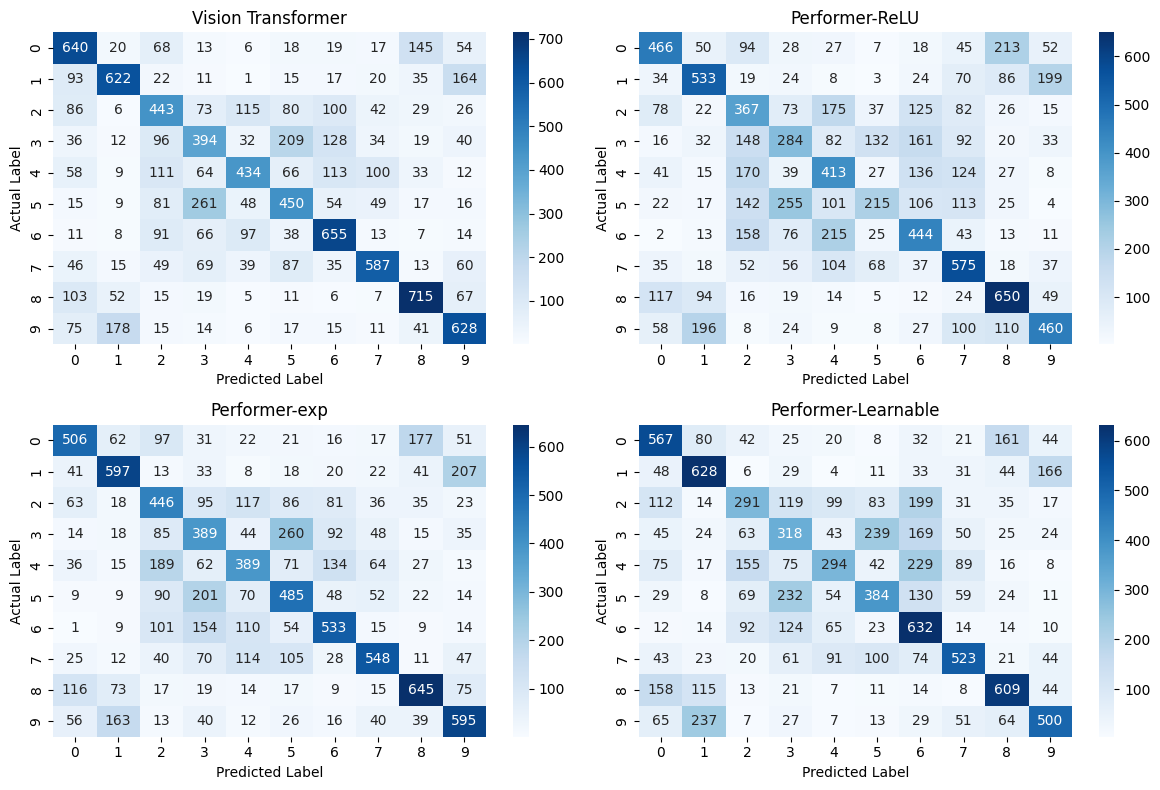

In [15]:
# Function to plot confusion matrix
def plot_confusion_matrix(model, dataloader, ax, model_name):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f'Evaluating {model_name}', leave=False):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'{model_name}')
    ax.set_ylabel('Actual Label')
    ax.set_xlabel('Predicted Label')

# List of models and their names
models = [
    (vit_model, 'Vision Transformer'),
    (performer_relu_model, 'Performer-ReLU'),
    (performer_exp_model, 'Performer-exp'),
    (performer_learnable_model, 'Performer-Learnable')
]

# Create a grid of subplots
num_models = len(models)
cols = 2
rows = (num_models + 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
axes = axes.flatten()

for idx, (model, model_name) in enumerate(models):
    plot_confusion_matrix(model, test_loader, axes[idx], model_name)

# Remove any unused subplots
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [32]:
# List of image file paths
image_paths = ['dog.jpeg', 'dog2.jpeg', 'car.jpeg']

# Load images
images = []
for path in image_paths:
    image = Image.open(path).convert('RGB').resize((32, 32))
    images.append(image)


# Access the class labels
class_labels = train_dataset.classes  # This is a list of class names
class_to_idx = train_dataset.class_to_idx  # This is a dictionary mapping class names to indices

print("Class Labels:")
for idx, label in enumerate(class_labels):
    print(f"{idx}: {label}")

Class Labels:
0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck


In [33]:
def classify_with_all_models(models, image):
    predictions = {}
    input_image = transform_test(image).unsqueeze(0).to(device)
    with torch.no_grad():
        for model_name, model in models.items():
            model.eval()
            outputs = model(input_image)
            _, predicted = outputs.max(1)
            predictions[model_name] = class_labels[predicted.item()]
    return predictions

In [34]:
models = {
    'Vision Transformer': vit_model,
    'Performer-ReLU': performer_relu_model,
    'Performer-exp': performer_exp_model,
    'Performer-Learnable': performer_learnable_model
}

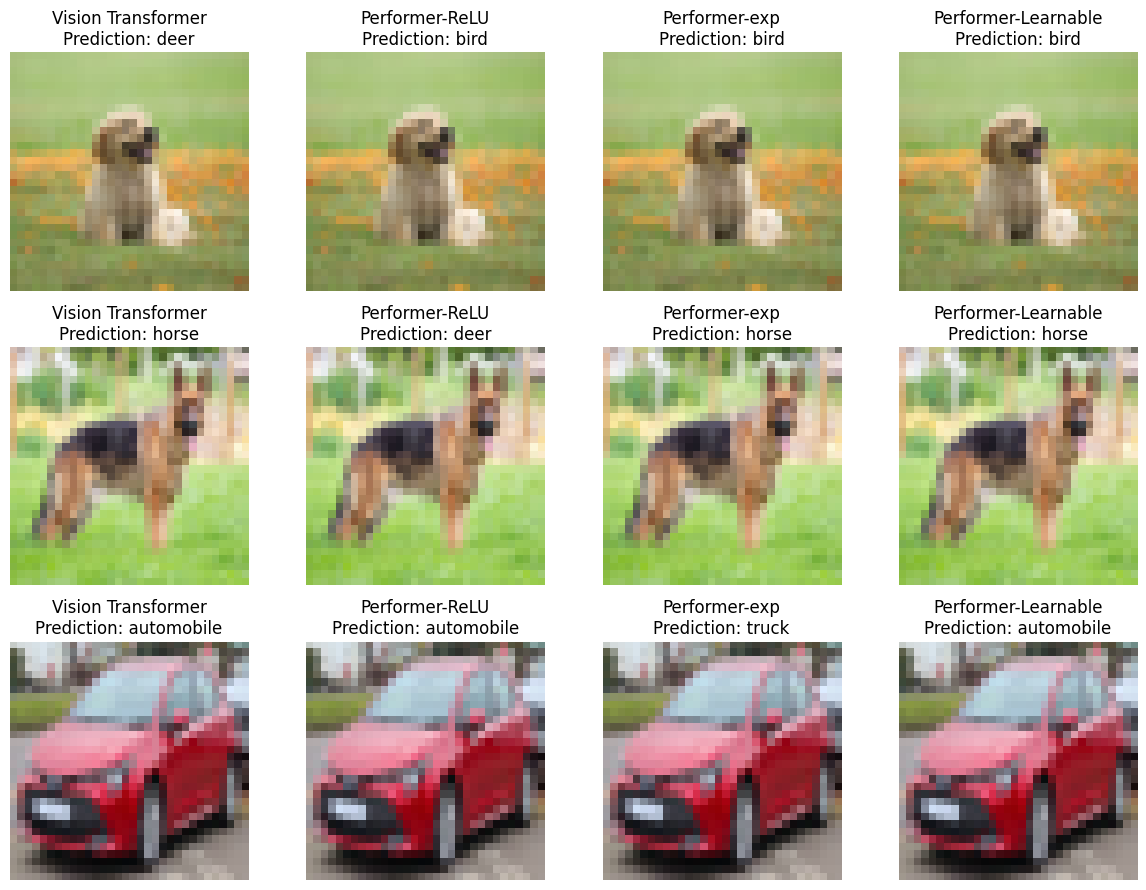

In [35]:
num_images = len(images)
num_models = len(models)
fig, axes = plt.subplots(num_images, num_models, figsize=(3 * num_models, 3 * num_images)
                         )
for i, image in enumerate(images):
    predictions = classify_with_all_models(models, image)
    for j, (model_name, prediction) in enumerate(predictions.items()):
        ax = axes[i, j] if num_images > 1 else axes[j]
        ax.imshow(image)
        ax.set_title(f'{model_name}\nPrediction: {prediction}')
        ax.axis('off')

plt.tight_layout()
plt.show()

In [37]:
# Read the CSV file without headers
df = pd.read_csv('results.csv', header=None)

# Assign headers manually
df.columns = ['Model', 'Total Training Time', 'Total Inference Time', 'Accuracy']

In [38]:
df

,Model,Total Training Time,Total Inference Time,Accuracy
0,ViT,366.984973,35.789836,10.00
1,Performer-ReLU,255.794168,35.383376,26.42
2,Performer-exp,50243.304063,125.857676,10.66
3,Performer-Learnable,680.754935,71.387063,10.38
4,ViT,128.313405,72.835719,10.00
5,Performer-ReLU,115.171755,73.731156,27.71
6,Performer-exp,313.132596,78.919237,27.20
7,Performer-Learnable,781.977693,75.211053,28.45
8,ViT,631.811621,372.347095,10.00
9,Performer-ReLU,563.935703,373.390441,39.49


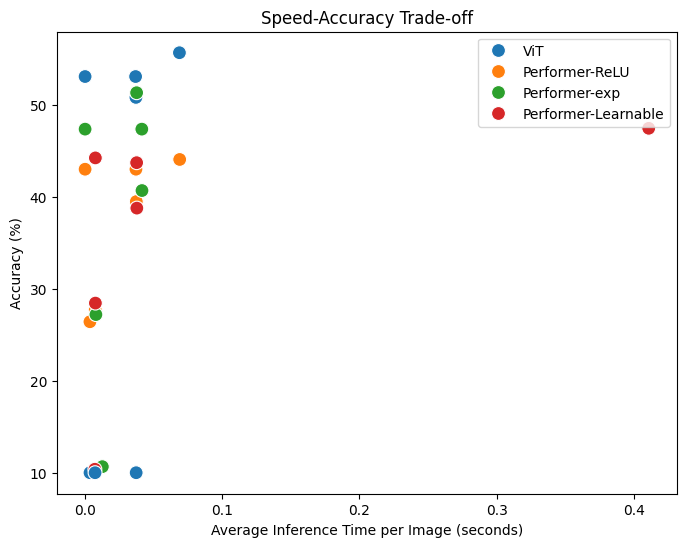

In [39]:
def plot_speed_accuracy():
    df['Avg Inference Time per Image'] = df['Total Inference Time'] / len(test_dataset)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x='Avg Inference Time per Image',
        y='Accuracy',
        hue='Model',
        data=df,
        s=100
    )
    plt.title('Speed-Accuracy Trade-off')
    plt.xlabel('Average Inference Time per Image (seconds)')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

plot_speed_accuracy()

/var/folders/l3/4qywm6wn4273cj1z5n54pm_h0000gn/T/ipykernel_79632/1921826076.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=df, palette='viridis')


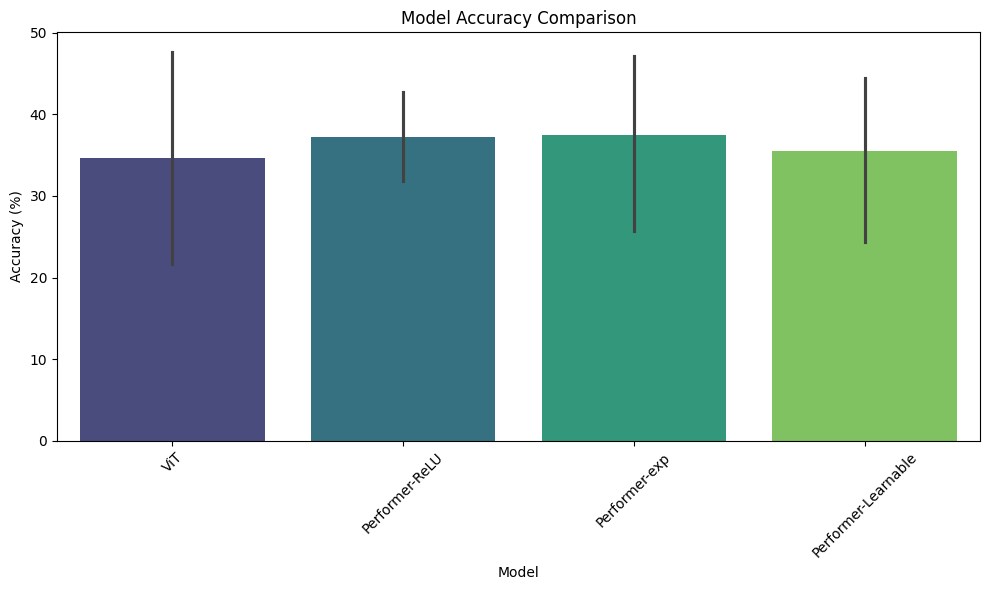

/var/folders/l3/4qywm6wn4273cj1z5n54pm_h0000gn/T/ipykernel_79632/1921826076.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model',y = 'Total Training Time', data=df, palette='magma')


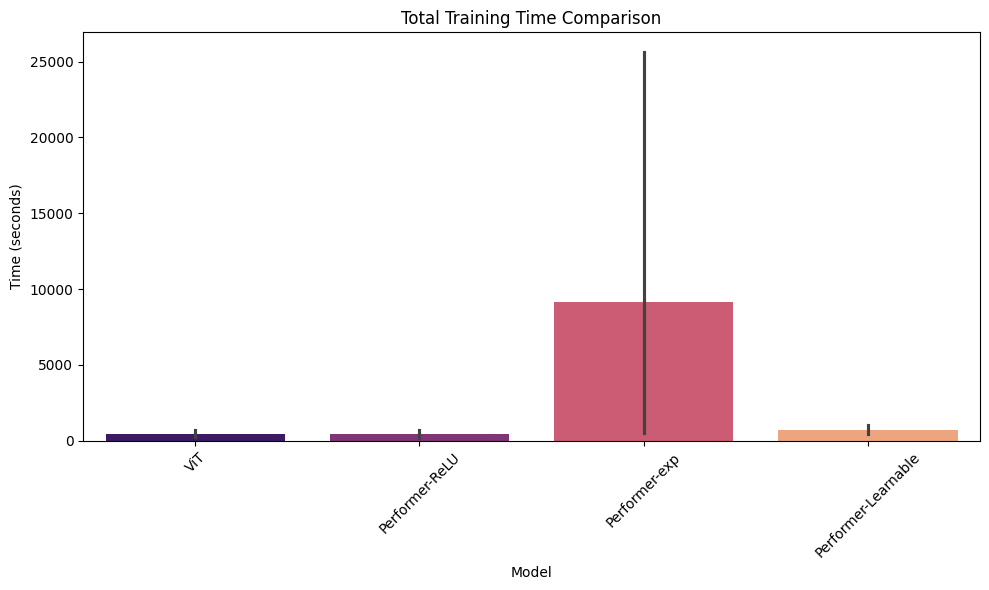

/var/folders/l3/4qywm6wn4273cj1z5n54pm_h0000gn/T/ipykernel_79632/1921826076.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y ='Total Inference Time', data=df, palette='coolwarm')


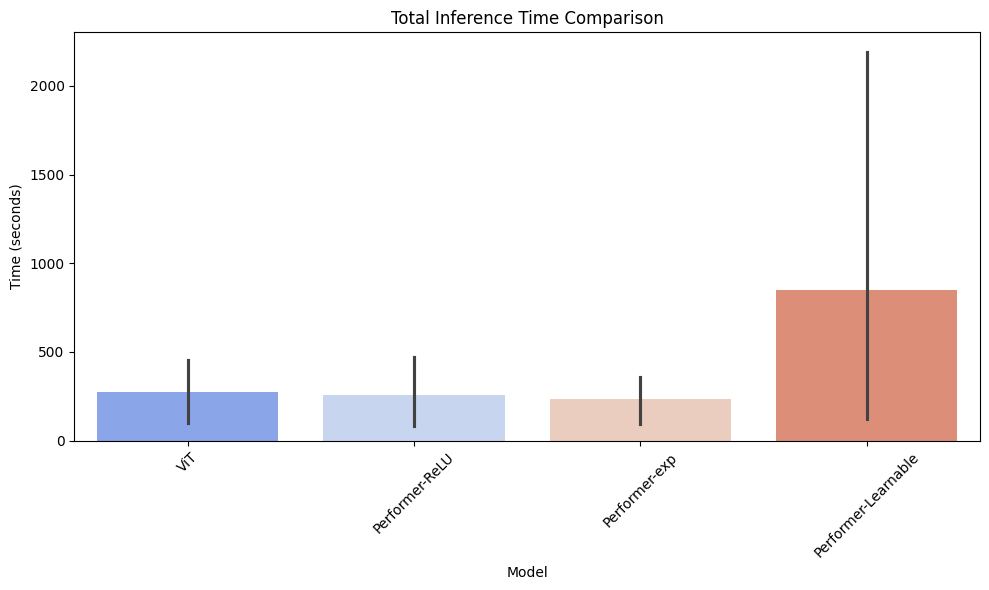

In [33]:
# Ensure numeric columns are of correct data type
df['Total Training Time'] = pd.to_numeric(df['Total Training Time'], errors='coerce')
df['Total Inference Time'] = pd.to_numeric(df['Total Inference Time'], errors='coerce')
df['Accuracy'] = pd.to_numeric(df['Accuracy'], errors='coerce')

# Plot Accuracy Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=df, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Total Training Time Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model',y = 'Total Training Time', data=df, palette='magma')
plt.title('Total Training Time Comparison')
plt.xlabel('Model')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Total Inference Time Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y ='Total Inference Time', data=df, palette='coolwarm')
plt.title('Total Inference Time Comparison')
plt.xlabel('Model')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

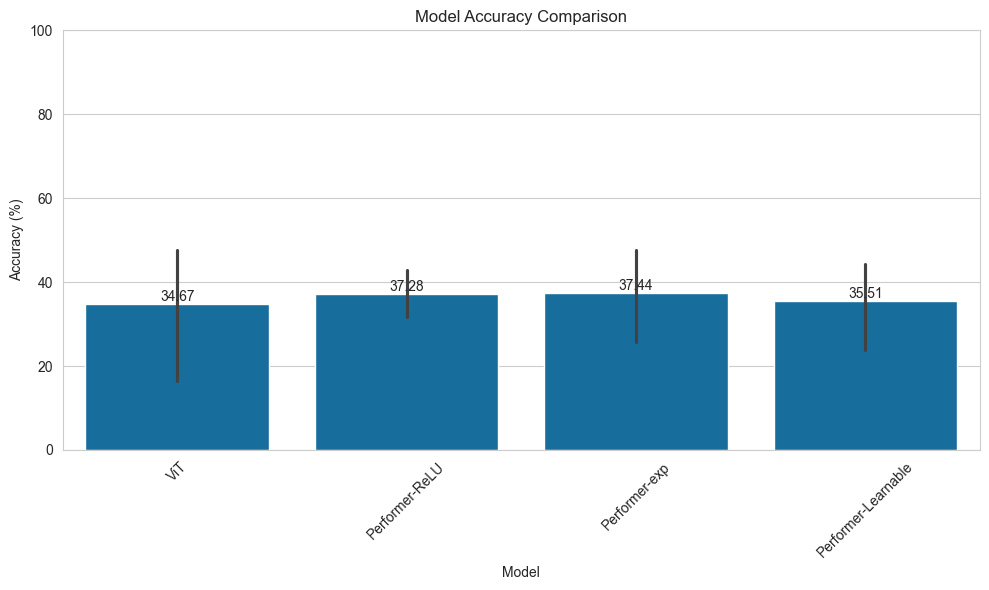

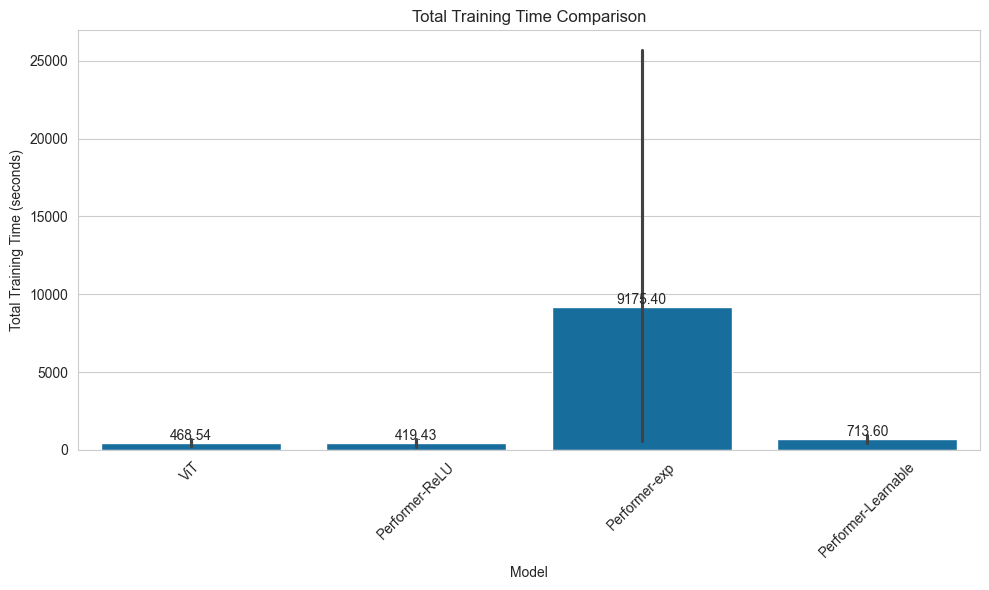

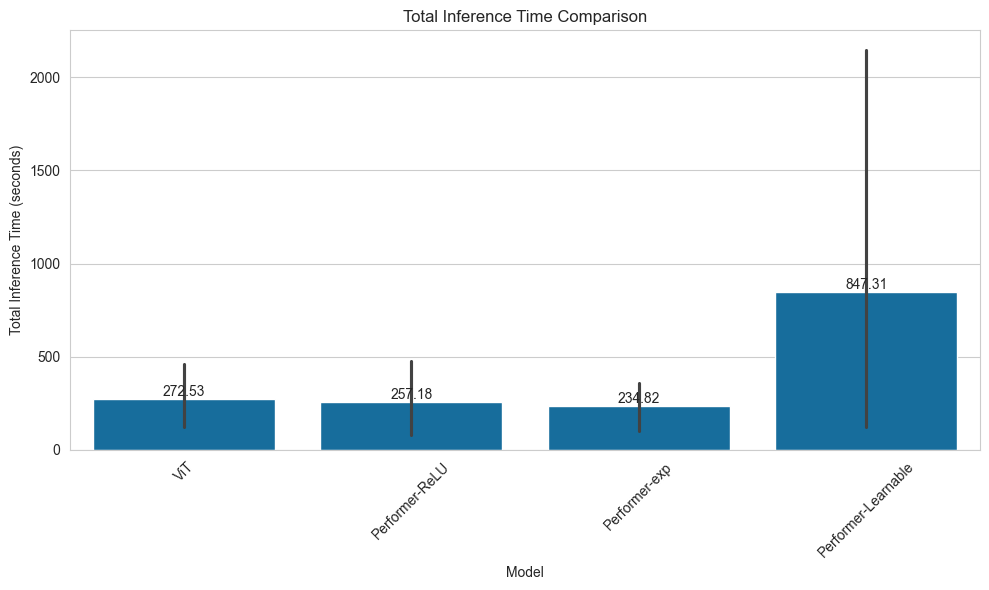

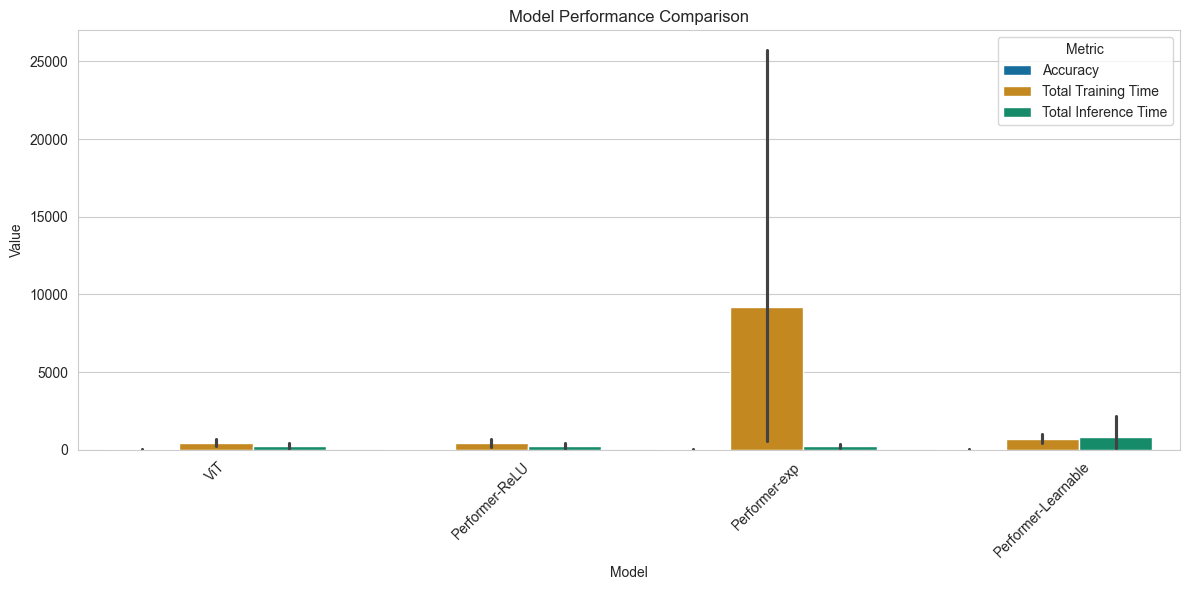

In [38]:


# Ensure numeric columns are of correct data type
df['Total Training Time'] = pd.to_numeric(df['Total Training Time'], errors='coerce')
df['Total Inference Time'] = pd.to_numeric(df['Total Inference Time'], errors='coerce')
df['Accuracy'] = pd.to_numeric(df['Accuracy'], errors='coerce')

# Function to add value labels on bars
def add_value_labels(ax):
    for p in ax.patches:
        _x = p.get_x() + p.get_width() / 2
        _y = p.get_height()
        value = f'{_y:.2f}'
        ax.text(_x, _y, value, ha='center', va='bottom')

# Set seaborn style
sns.set_style('whitegrid')
sns.set_palette('colorblind')

# Plot Accuracy Comparison
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Accuracy', data=df)
add_value_labels(ax)
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Total Training Time Comparison
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Total Training Time', data=df)
add_value_labels(ax)
plt.title('Total Training Time Comparison')
plt.xlabel('Model')
plt.ylabel('Total Training Time (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Total Inference Time Comparison
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Total Inference Time', data=df)
add_value_labels(ax)
plt.title('Total Inference Time Comparison')
plt.xlabel('Model')
plt.ylabel('Total Inference Time (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create grouped bar chart for all metrics
metrics = ['Accuracy', 'Total Training Time', 'Total Inference Time']
df_melted = df.melt(id_vars='Model', value_vars=metrics,
                    var_name='Metric', value_name='Value')

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Model', y='Value', hue='Metric', data=df_melted)
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Value')
plt.legend(title='Metric')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()